## Import the required packages

In [90]:
#Import package pandas for data analysis
import pandas as pd
# Import package numpy for numeric computing
import numpy as np
import seaborn as sns
# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import pymysql

import matplotlib.pyplot as plt

#For showing plots directly in the notebook run the command below
%matplotlib inline

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

import scipy.stats as ss

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Connect to mysql

In [3]:
from sshtunnel import SSHTunnelForwarder
import pymysql
import pandas as pd

server = SSHTunnelForwarder(
ssh_address=('ipa-008.ucd.ie', 22),
ssh_username="wingki",
ssh_password="6!#5/6_Dublinbus",
remote_bind_address=("localhost", 3306))

server.start()

con = pymysql.connect(user='root',passwd='Dublinbus_6!#5/6',db='dublinbus',host='localhost',port=server.local_bind_port)

## Clean route data

In [4]:
# Reading from mysql, into a data frame

# Read more about .read_csv() here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

#read data from route table
routeData = pd.read_sql_query("SELECT * FROM dublinbus.route_1;", con)

In [5]:
# Show first few rows
routeData.head(10)

,DAYOFSERVICE,TRIPID,LINEID,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR
0,07-FEB-18 00:00:00,6253554,1,1,381,2,63629,63629
1,07-FEB-18 00:00:00,6253554,1,2,382,2,63690,63675
2,07-FEB-18 00:00:00,6253554,1,3,4451,2,63739,63715
3,07-FEB-18 00:00:00,6253554,1,4,383,2,63788,63774
4,07-FEB-18 00:00:00,6253554,1,5,384,2,63824,63824
5,07-FEB-18 00:00:00,6253554,1,6,385,2,63897,63869
6,07-FEB-18 00:00:00,6253554,1,8,388,2,64084,64084
7,07-FEB-18 00:00:00,6253554,1,9,389,2,64097,64097
8,07-FEB-18 00:00:00,6253554,1,10,393,2,64283,64283
9,07-FEB-18 00:00:00,6253554,1,11,371,2,64344,64314


In [6]:
#start by fixing date datatype 
routeData['DAYOFSERVICE'] = pd.to_datetime(routeData.DAYOFSERVICE)

In [7]:
routeData.head(10)

,DAYOFSERVICE,TRIPID,LINEID,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR
0,2018-02-07,6253554,1,1,381,2,63629,63629
1,2018-02-07,6253554,1,2,382,2,63690,63675
2,2018-02-07,6253554,1,3,4451,2,63739,63715
3,2018-02-07,6253554,1,4,383,2,63788,63774
4,2018-02-07,6253554,1,5,384,2,63824,63824
5,2018-02-07,6253554,1,6,385,2,63897,63869
6,2018-02-07,6253554,1,8,388,2,64084,64084
7,2018-02-07,6253554,1,9,389,2,64097,64097
8,2018-02-07,6253554,1,10,393,2,64283,64283
9,2018-02-07,6253554,1,11,371,2,64344,64314


In [8]:
#Next see what columns are unnecessary and drop them 
routeData.columns

Index(['DAYOFSERVICE', 'TRIPID', 'LINEID', 'PROGRNUMBER', 'STOPPOINTID',
       'DIRECTION', 'ACTUALTIME_DEP', 'ACTUALTIME_ARR'],
      dtype='object')

In [9]:
#drop columns that won't be used
routeData.drop(['LINEID'], axis = 1, inplace=True) 
routeData.drop(['TRIPID'], axis = 1, inplace=True) 

In [10]:
routeData.columns

Index(['DAYOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 'DIRECTION',
       'ACTUALTIME_DEP', 'ACTUALTIME_ARR'],
      dtype='object')

In [11]:
#create a new hour column by converting the actual deperature time to hour
routeData['hour'] = pd.to_datetime(routeData['ACTUALTIME_DEP'], unit='s').dt.hour

In [12]:
# Create new column dayofweek based on the DAYOFSERVICE
# if it is a weekday, value=0; if it is a weekend, value=1
conditions = [
    (routeData['DAYOFSERVICE'].dt.dayofweek == 5),(routeData['DAYOFSERVICE'].dt.dayofweek == 6)
    ]
choices = [1,1]
routeData['dayofweek'] = np.select(conditions, choices, default=0)

In [13]:
routeData.head() 

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR,hour,dayofweek
0,2018-02-07,1,381,2,63629,63629,17,0
1,2018-02-07,2,382,2,63690,63675,17,0
2,2018-02-07,3,4451,2,63739,63715,17,0
3,2018-02-07,4,383,2,63788,63774,17,0
4,2018-02-07,5,384,2,63824,63824,17,0


In [14]:
routeData.dtypes

DAYOFSERVICE      datetime64[ns]
PROGRNUMBER                int64
STOPPOINTID               object
DIRECTION                 object
ACTUALTIME_DEP             int64
ACTUALTIME_ARR             int64
hour                       int64
dayofweek                  int64
dtype: object

In [15]:
#fix orther dtypes
routeData['DIRECTION'] = routeData['DIRECTION'].astype('int64')

In [16]:
numeric_columns = routeData.select_dtypes(['int64']).columns
columns = list(routeData)

In [17]:
#have a look at max and min values to check if have any iregualr values
for col in numeric_columns:
    print("Max ", col, ":", routeData[col].max())
    print("Min ", col, ":", routeData[col].min())

Max  PROGRNUMBER : 43
Min  PROGRNUMBER : 1
Max  DIRECTION : 2
Min  DIRECTION : 1
Max  ACTUALTIME_DEP : 87714
Min  ACTUALTIME_DEP : 22841
Max  ACTUALTIME_ARR : 87714
Min  ACTUALTIME_ARR : 22841
Max  hour : 23
Min  hour : 0
Max  dayofweek : 1
Min  dayofweek : 0


## Clean weather table

In [18]:
#read data from weather.csv
weatherData = pd.read_csv('weather-data-cleaned.csv', keep_default_na=True, delimiter=',')

In [19]:
# Show first few rows
weatherData.head(10)

,Unnamed: 0,datetime,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover
0,245448,2018-01-01 00:00:00,0.0,4.5,6.8,6,23,240,0.0,16000,168,7
1,245449,2018-01-01 01:00:00,0.0,4.4,7.0,7,25,240,0.0,20000,250,5
2,245450,2018-01-01 02:00:00,0.0,4.6,7.0,7,23,240,0.0,20000,999,3
3,245451,2018-01-01 03:00:00,0.0,4.6,7.1,7,24,240,0.0,30000,999,4
4,245452,2018-01-01 04:00:00,0.0,5.1,7.2,7,21,240,0.0,25000,999,4
5,245453,2018-01-01 05:00:00,0.0,5.0,6.9,6,21,240,0.0,25000,230,6
6,245454,2018-01-01 06:00:00,0.0,4.8,7.1,7,15,230,0.0,30000,180,7
7,245455,2018-01-01 07:00:00,0.0,4.3,7.1,7,12,230,0.0,30000,160,7
8,245456,2018-01-01 08:00:00,0.0,4.0,7.0,7,12,230,0.0,30000,170,7
9,245457,2018-01-01 09:00:00,0.0,4.6,7.1,7,14,240,0.2,30000,999,3


In [20]:
#drop no use column Unnamed: 0
weatherData.drop(['Unnamed: 0'], axis = 1, inplace=True) 

The data is already cleaned we just need to seperate and rename datetime for future joining 

In [21]:
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
#efficient way to extract hour from datetime
weatherData['hour'] = pd.DatetimeIndex(weatherData['datetime']).hour
weatherData.head()

,datetime,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover,hour
0,2018-01-01 00:00:00,0.0,4.5,6.8,6,23,240,0.0,16000,168,7,0
1,2018-01-01 01:00:00,0.0,4.4,7.0,7,25,240,0.0,20000,250,5,1
2,2018-01-01 02:00:00,0.0,4.6,7.0,7,23,240,0.0,20000,999,3,2
3,2018-01-01 03:00:00,0.0,4.6,7.1,7,24,240,0.0,30000,999,4,3
4,2018-01-01 04:00:00,0.0,5.1,7.2,7,21,240,0.0,25000,999,4,4


In [22]:
#only keep date
weatherData['datetime'] = pd.to_datetime(weatherData['datetime']).dt.date

In [23]:
#rename the datetime column after extracting date to make it more convenient for future joining
weatherData.rename(columns = {'datetime':'DAYOFSERVICE'}, inplace = True)

In [24]:
weatherData.head()

,DAYOFSERVICE,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover,hour
0,2018-01-01,0.0,4.5,6.8,6,23,240,0.0,16000,168,7,0
1,2018-01-01,0.0,4.4,7.0,7,25,240,0.0,20000,250,5,1
2,2018-01-01,0.0,4.6,7.0,7,23,240,0.0,20000,999,3,2
3,2018-01-01,0.0,4.6,7.1,7,24,240,0.0,30000,999,4,3
4,2018-01-01,0.0,5.1,7.2,7,21,240,0.0,25000,999,4,4


In [25]:
weatherData.dtypes

DAYOFSERVICE     object
rain            float64
temp            float64
pressure        float64
humidity          int64
wind_speed        int64
wind_dir          int64
sun             float64
visibility        int64
cloud_height      int64
cloud_cover       int64
hour              int64
dtype: object

In [26]:
#convert 'DAYOFSERVICE' to datetime data type
weatherData['DAYOFSERVICE'] = pd.to_datetime(weatherData.DAYOFSERVICE)

In [27]:
weatherData.dtypes

DAYOFSERVICE    datetime64[ns]
rain                   float64
temp                   float64
pressure               float64
humidity                 int64
wind_speed               int64
wind_dir                 int64
sun                    float64
visibility               int64
cloud_height             int64
cloud_cover              int64
hour                     int64
dtype: object

## Combine route data and weather data

In [28]:
df=pd.merge(routeData, weatherData, how='inner', left_on=['DAYOFSERVICE', 'hour'], right_on=['DAYOFSERVICE','hour'])

In [29]:
# Show first few rows
df.head(10)

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR,hour,dayofweek,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover
0,2018-02-07,1,381,2,63629,63629,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
1,2018-02-07,2,382,2,63690,63675,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
2,2018-02-07,3,4451,2,63739,63715,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
3,2018-02-07,4,383,2,63788,63774,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
4,2018-02-07,5,384,2,63824,63824,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
5,2018-02-07,6,385,2,63897,63869,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
6,2018-02-07,8,388,2,64084,64084,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
7,2018-02-07,9,389,2,64097,64097,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
8,2018-02-07,10,393,2,64283,64283,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7
9,2018-02-07,11,371,2,64344,64314,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7


In [30]:
df.dtypes

DAYOFSERVICE      datetime64[ns]
PROGRNUMBER                int64
STOPPOINTID               object
DIRECTION                  int64
ACTUALTIME_DEP             int64
ACTUALTIME_ARR             int64
hour                       int64
dayofweek                  int64
rain                     float64
temp                     float64
pressure                 float64
humidity                   int64
wind_speed                 int64
wind_dir                   int64
sun                      float64
visibility                 int64
cloud_height               int64
cloud_cover                int64
dtype: object

## Clean holiday data

In [31]:
#read data from holiday.csv
#reference: https://www.generalblue.com/calendar/ireland/ireland-holidays-2018/
holidayData = pd.read_csv('ireland-holidays-2018-list-classic-en-ie.csv', keep_default_na=True, delimiter=',')

In [32]:
#Show rows
holidayData

,date,nameOfHoliday
0,"January 1, 2018",New Year's Day
1,"March 11, 2018",Mother's Day
2,"March 17, 2018",St. Patrick’s Day
3,"March 19, 2018",St. Patrick’s Day (substitute day)
4,"March 30, 2018",Good Friday
...,...,...
152,NaN,NaN
153,NaN,NaN
154,NaN,NaN
155,NaN,NaN


In [33]:
#drop all rows that have any NaN values
holidayData.dropna(inplace=True) 

In [34]:
holidayData.dtypes

date             object
nameOfHoliday    object
dtype: object

In [35]:
#start by fixing date datatype 
holidayData['date'] = pd.to_datetime(holidayData.date)

In [36]:
holidayData.head(20)

,date,nameOfHoliday
0,2018-01-01,New Year's Day
1,2018-03-11,Mother's Day
2,2018-03-17,St. Patrick’s Day
3,2018-03-19,St. Patrick’s Day (substitute day)
4,2018-03-30,Good Friday
5,2018-04-01,Easter Sunday
6,2018-04-02,Easter Monday
7,2018-05-07,May Day
8,2018-06-04,First Monday in June
9,2018-08-06,First Monday in August


In [37]:
#Create a daily datetime index using the start and end times from a period with yearly frequency
#reference: https://stackoverflow.com/questions/20602947/append-column-to-pandas-dataframe
year = '2018'
df1 = pd.DataFrame({
    'Date': pd.date_range(
        start = pd.Timestamp(year),                        
        end = pd.Timestamp(year) + pd.offsets.YearEnd(0),  
        freq = 'D'
    )
})

In [38]:
df1.head(10)

,Date
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
5,2018-01-06
6,2018-01-07
7,2018-01-08
8,2018-01-09
9,2018-01-10


In [39]:
# join the Date to holidayData
holidayData=df1.join(holidayData)

In [40]:
# create a new column "holiday in holidayData" and set default cell value to be 0, indicating not a holiday
# set the dates of summer holiday to 2
start_date='2018-06-21'
end_date='2018-09-23'
conditions = [
    (holidayData['Date'] >= start_date) & (holidayData['Date'] <= end_date)
    ]
choices = [2]
holidayData['holiday'] = np.select(conditions, choices,default=0)

In [41]:
# flip those dates with bank holiday to 1 in "holiday" column
holidayData.loc[holidayData['Date']=='2018-01-01', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-03-11', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-03-17', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-03-19', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-03-30', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-04-01', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-04-02', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-05-07', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-06-04', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-08-06', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-10-29', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-12-25', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-12-26', 'holiday'] = 1
holidayData.loc[holidayData['Date']=='2018-12-27', 'holiday'] = 1

In [42]:
#check again if flip based on the right bank holidays
holidayData[holidayData['holiday']==1]

,Date,date,nameOfHoliday,holiday
0,2018-01-01,2018-01-01,New Year's Day,1
69,2018-03-11,NaT,NaN,1
75,2018-03-17,NaT,NaN,1
77,2018-03-19,NaT,NaN,1
88,2018-03-30,NaT,NaN,1
90,2018-04-01,NaT,NaN,1
91,2018-04-02,NaT,NaN,1
126,2018-05-07,NaT,NaN,1
154,2018-06-04,NaT,NaN,1
217,2018-08-06,NaT,NaN,1


In [43]:
holidayData.head(10)

,Date,date,nameOfHoliday,holiday
0,2018-01-01,2018-01-01,New Year's Day,1
1,2018-01-02,2018-03-11,Mother's Day,0
2,2018-01-03,2018-03-17,St. Patrick’s Day,0
3,2018-01-04,2018-03-19,St. Patrick’s Day (substitute day),0
4,2018-01-05,2018-03-30,Good Friday,0
5,2018-01-06,2018-04-01,Easter Sunday,0
6,2018-01-07,2018-04-02,Easter Monday,0
7,2018-01-08,2018-05-07,May Day,0
8,2018-01-09,2018-06-04,First Monday in June,0
9,2018-01-10,2018-08-06,First Monday in August,0


In [44]:
# for row_index in range(len(holidayData["Date"])): #for each row index of length of column "Date"
    
#     column_index_Date=holidayData.columns.get_loc("Date") #get column index of "Date"
#     cell=holidayData.iat[row_index, column_index_Date] #get content of the cell based on row and column index
#     column_index_holiday=holidayData.columns.get_loc("holiday")
#     column_index_date=holidayData.columns.get_loc("date")

#     #change the cell value of holiday to 1 if match the Date match date(holiday)
#     for row_index1 in range(len(holidayData["date"])):
#         if cell == holidayData.iat[row_index1, column_index_date]:
#             holidayData.iloc[[row_index], [column_index_holiday]]=1
    

In [45]:
#drop nameOfHoliday and date that won't be used
holidayData.drop(['nameOfHoliday'], axis = 1, inplace=True) 
holidayData.drop(['date'], axis = 1, inplace=True) 

In [46]:
#rename the date column to make it more convenient for future joining
holidayData.rename(columns = {'Date':'DAYOFSERVICE'}, inplace = True)

In [47]:
holidayData.head()

,DAYOFSERVICE,holiday
0,2018-01-01,1
1,2018-01-02,0
2,2018-01-03,0
3,2018-01-04,0
4,2018-01-05,0


In [48]:
holidayData.dtypes

DAYOFSERVICE    datetime64[ns]
holiday                  int64
dtype: object

## Add holiday data to dataframe

In [49]:
df=pd.merge(df, holidayData, how='inner', left_on=['DAYOFSERVICE'], right_on=['DAYOFSERVICE'])

In [50]:
df

,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR,hour,dayofweek,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover,holiday
0,2018-02-07,1,381,2,63629,63629,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
1,2018-02-07,2,382,2,63690,63675,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
2,2018-02-07,3,4451,2,63739,63715,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
3,2018-02-07,4,383,2,63788,63774,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
4,2018-02-07,5,384,2,63824,63824,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336955,2018-01-07,35,373,1,85448,85448,23,1,0.0,1.9,4.7,4,10,100,0.0,30000,999,3,0
1336956,2018-01-07,13,44,1,83332,83320,23,1,0.0,1.9,4.7,4,10,100,0.0,30000,999,3,0
1336957,2018-01-07,34,372,1,85428,85428,23,1,0.0,1.9,4.7,4,10,100,0.0,30000,999,3,0
1336958,2018-01-07,1,226,1,82827,82827,23,1,0.0,1.9,4.7,4,10,100,0.0,30000,999,3,0


In [51]:
df.dtypes

DAYOFSERVICE      datetime64[ns]
PROGRNUMBER                int64
STOPPOINTID               object
DIRECTION                  int64
ACTUALTIME_DEP             int64
ACTUALTIME_ARR             int64
hour                       int64
dayofweek                  int64
rain                     float64
temp                     float64
pressure                 float64
humidity                   int64
wind_speed                 int64
wind_dir                   int64
sun                      float64
visibility                 int64
cloud_height               int64
cloud_cover                int64
holiday                    int64
dtype: object

In [52]:
df.to_csv('line1.csv')

## Build linear regression model for bus departure

In [53]:
df = pd.read_csv('line1.csv', keep_default_na=True, delimiter=',')

In [54]:
df.head()

,Unnamed: 0,DAYOFSERVICE,PROGRNUMBER,STOPPOINTID,DIRECTION,ACTUALTIME_DEP,ACTUALTIME_ARR,hour,dayofweek,rain,temp,pressure,humidity,wind_speed,wind_dir,sun,visibility,cloud_height,cloud_cover,holiday
0,0,2018-02-07,1,381,2,63629,63629,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
1,1,2018-02-07,2,382,2,63690,63675,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
2,2,2018-02-07,3,4451,2,63739,63715,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
3,3,2018-02-07,4,383,2,63788,63774,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0
4,4,2018-02-07,5,384,2,63824,63824,17,0,0.2,2.9,6.7,6,9,210,0.0,25000,40,7,0


In [55]:
# drop unrelated columns
df = df.drop(columns=['Unnamed: 0','ACTUALTIME_ARR'])

In [56]:
df.nunique()

DAYOFSERVICE        360
PROGRNUMBER          43
STOPPOINTID          84
DIRECTION             2
ACTUALTIME_DEP    62658
hour                 19
dayofweek             2
rain                 41
temp                292
pressure            172
humidity             19
wind_speed           33
wind_dir             36
sun                  11
visibility           55
cloud_height         72
cloud_cover           9
holiday               3
dtype: int64

In [57]:
#check if any null column
df.isnull().sum()

DAYOFSERVICE      0
PROGRNUMBER       0
STOPPOINTID       0
DIRECTION         0
ACTUALTIME_DEP    0
hour              0
dayofweek         0
rain              0
temp              0
pressure          0
humidity          0
wind_speed        0
wind_dir          0
sun               0
visibility        0
cloud_height      0
cloud_cover       0
holiday           0
dtype: int64

In [58]:
df.dtypes

DAYOFSERVICE       object
PROGRNUMBER         int64
STOPPOINTID         int64
DIRECTION           int64
ACTUALTIME_DEP      int64
hour                int64
dayofweek           int64
rain              float64
temp              float64
pressure          float64
humidity            int64
wind_speed          int64
wind_dir            int64
sun               float64
visibility          int64
cloud_height        int64
cloud_cover         int64
holiday             int64
dtype: object

In [59]:
df['DAYOFSERVICE'] = df['DAYOFSERVICE'].astype('datetime64') #convert DAYOFSERVICE to datetime

In [60]:
#change datatypes of some features
df['DAYOFSERVICE']=df['DAYOFSERVICE'].apply(lambda x: x.toordinal()) #then convert it to numeric
df['dayofweek'] = df['dayofweek'].astype('category')
df['hour'] = df['hour'].astype('category')
df.dtypes

DAYOFSERVICE         int64
PROGRNUMBER          int64
STOPPOINTID          int64
DIRECTION            int64
ACTUALTIME_DEP       int64
hour              category
dayofweek         category
rain               float64
temp               float64
pressure           float64
humidity             int64
wind_speed           int64
wind_dir             int64
sun                float64
visibility           int64
cloud_height         int64
cloud_cover          int64
holiday              int64
dtype: object

##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be actual departure time
- Then we will set "X" to be the remaining features in the dataframe

In [61]:
y = pd.DataFrame(df["ACTUALTIME_DEP"])
X = df.drop(["ACTUALTIME_DEP"],1)

The data set can now be split
The train test split will randomly split the dataset as per the test size
We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [62]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  1336960
training range (70%):	 rows 0 to 935872
test range (30%): 	 rows 935872 to 1336960


In [63]:
continuous_columns = X.select_dtypes(['int64','float64']).columns
X[continuous_columns].dtypes

DAYOFSERVICE      int64
PROGRNUMBER       int64
STOPPOINTID       int64
DIRECTION         int64
rain            float64
temp            float64
pressure        float64
humidity          int64
wind_speed        int64
wind_dir          int64
sun             float64
visibility        int64
cloud_height      int64
cloud_cover       int64
holiday           int64
dtype: object

In [64]:
categorical_columns = df.select_dtypes(['category']).columns
df[categorical_columns].dtypes

hour         category
dayofweek    category
dtype: object

### On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model
All plots will be using the training subset of dataset: X_train, y_train

### Plot the correlations between all the continuous features.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text xticklabel objects>)

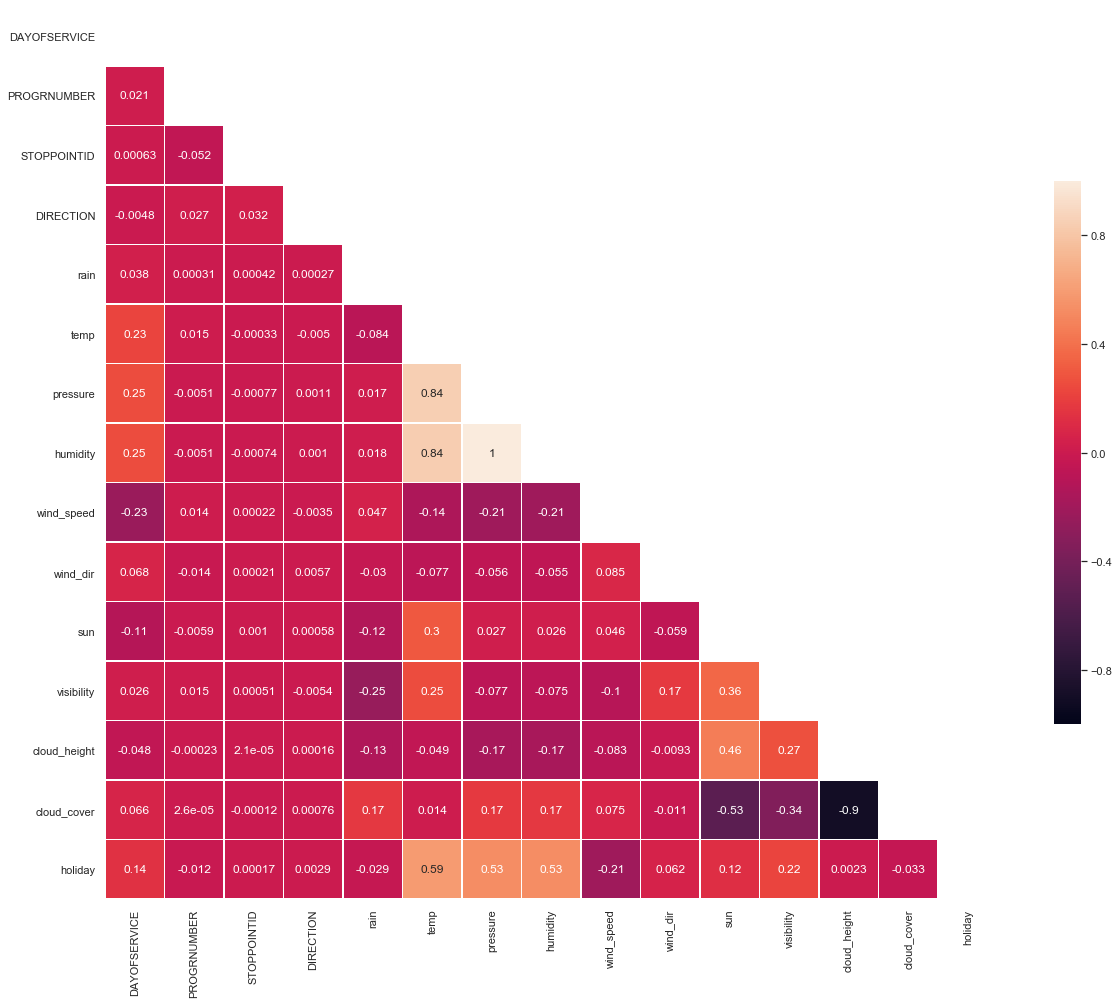

In [65]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

Interpretation of the results

Strong correlations - We can see clearly from the above heat map that there are a number of features that have 
strong correlations
- 'temp' vs 'pressure' and 'humidity'  (0.84) - This is to be expected - We only need to keep one of these features
- 'pressure' vs 'humidity' (1) - This is to be expected - We only need to keep one of these features

Weak correlations - We can see some features with no apparent correlation to almost any other features
- 'cloud_height' - we will check this feature against the target later and if no strong correlation we can remove then 
**Current status : Drop pressure, humidity**

### Plot interaction between continuous features and target feature
Here we will loop over each continuous feature and make a scatter plot against the target 'ACTUALTIME_DEP'
We will discuss what we observe from these plots, e.g. which continuous features seem to be better at predicting the target feature
We will choose a subset of continuous features we find promising (if any) and justify our choice.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

,ACTUALTIME_DEP
PROGRNUMBER,0.124312
cloud_height,0.061370
visibility,0.024849
holiday,0.016677
STOPPOINTID,-0.000574
humidity,-0.007856
pressure,-0.008377
temp,-0.009682
DAYOFSERVICE,-0.023906
DIRECTION,-0.026662


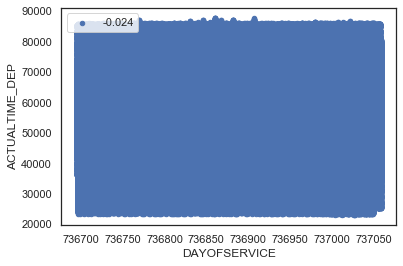

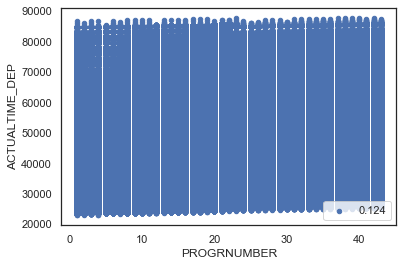

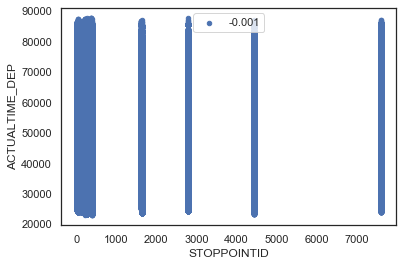

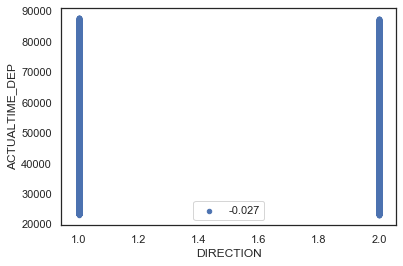

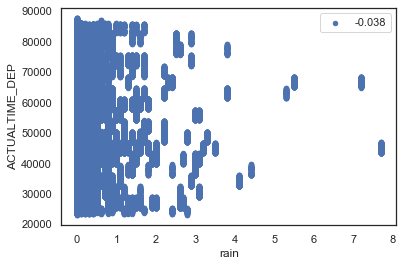

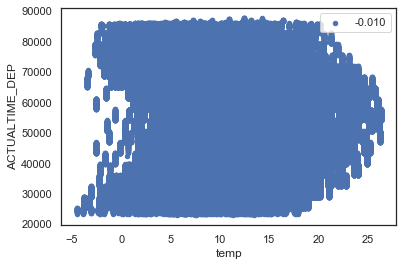

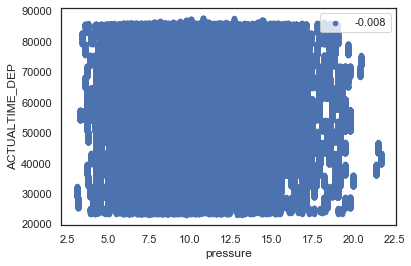

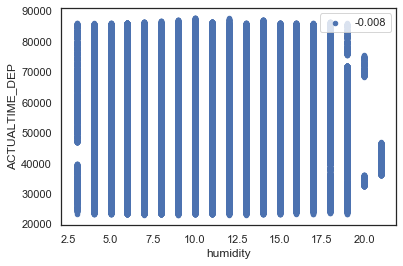

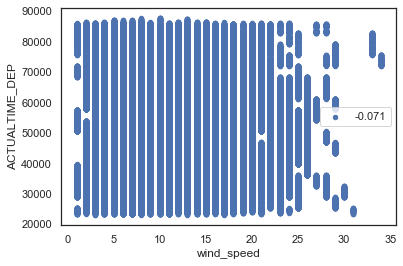

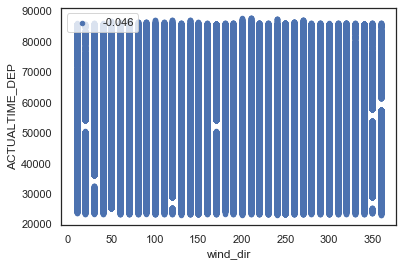

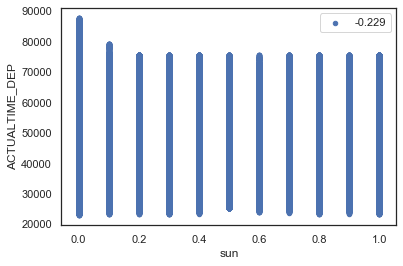

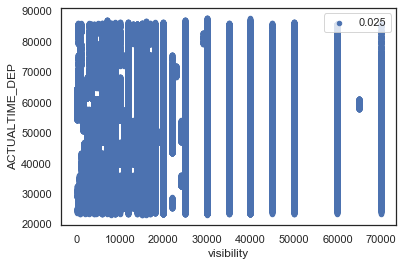

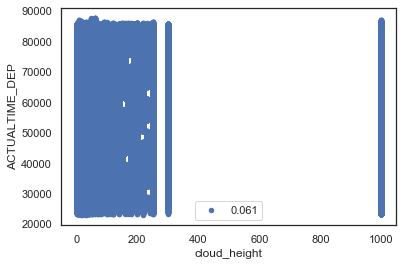

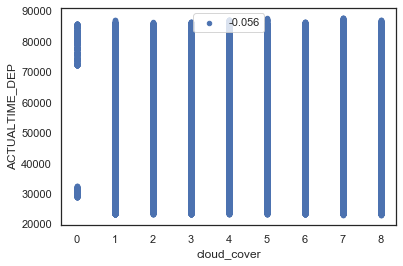

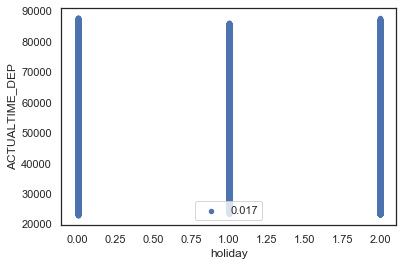

In [66]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "ACTUALTIME_DEP"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="ACTUALTIME_DEP", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['ACTUALTIME_DEP']).sort_values('ACTUALTIME_DEP', ascending=False)
corr_df

We can see from above that DAYOFSERVICE, rain, wind_dir, cloud_cover, wind_speed and DIRECTION and sun all have weak correlation with ACTUALTIME_DEP, so they will be dropped.

In [67]:
low_information_gain = ['DAYOFSERVICE','rain', 'wind_dir','cloud_cover','wind_speed','DIRECTION','pressure','humidity','sun']

### Plot interaction between categorical features and target feature

<Figure size 432x288 with 0 Axes>

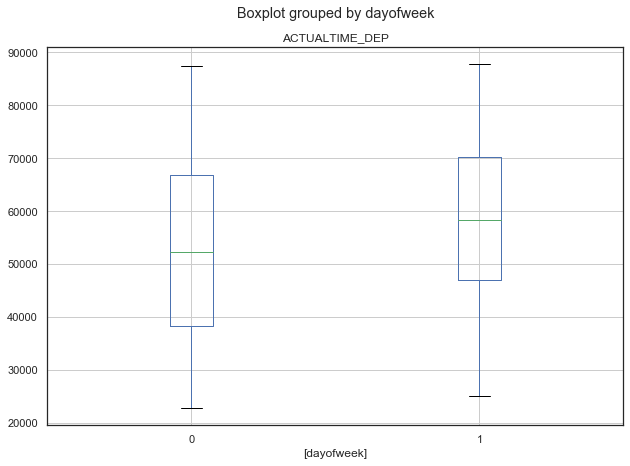

In [68]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['ACTUALTIME_DEP'], by=['dayofweek'], flierprops=flierprops, figsize=(10,7))

<Figure size 432x288 with 0 Axes>

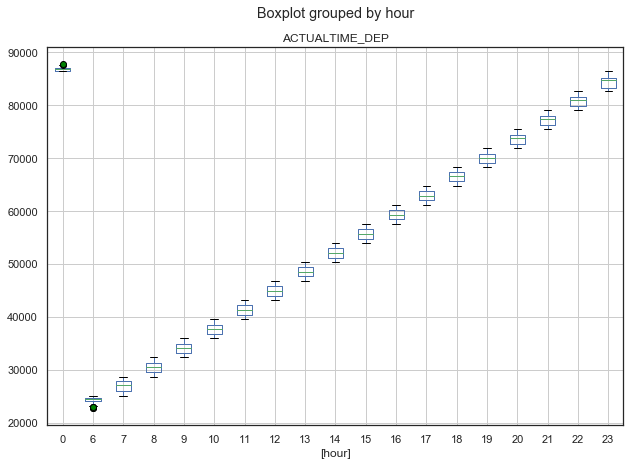

In [69]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['ACTUALTIME_DEP'], by=['hour'], flierprops=flierprops, figsize=(10,7))

In [70]:
# drop the useless column
df_rev1 = df.copy()
# drop low value features
df_rev1.drop(low_information_gain, 1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['PROGRNUMBER', 'STOPPOINTID', 'ACTUALTIME_DEP', 'hour', 'dayofweek',
       'temp', 'visibility', 'cloud_height', 'holiday'],
      dtype='object')

New shape: (1336960, 9)


In [71]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1)
df_rev1.dtypes

PROGRNUMBER         int64
STOPPOINTID         int64
ACTUALTIME_DEP      int64
temp              float64
visibility          int64
cloud_height        int64
holiday             int64
hour_0              uint8
hour_6              uint8
hour_7              uint8
hour_8              uint8
hour_9              uint8
hour_10             uint8
hour_11             uint8
hour_12             uint8
hour_13             uint8
hour_14             uint8
hour_15             uint8
hour_16             uint8
hour_17             uint8
hour_18             uint8
hour_19             uint8
hour_20             uint8
hour_21             uint8
hour_22             uint8
hour_23             uint8
dayofweek_0         uint8
dayofweek_1         uint8
dtype: object

In [72]:
# y is the target
y = df_rev1["ACTUALTIME_DEP"]
# X is everything else
X = df_rev1.drop(["ACTUALTIME_DEP"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  1336960
training range (70%):	 rows 0 to 935872
test range (30%): 	 rows 935872 to 1336960


In [73]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
          PROGRNUMBER  STOPPOINTID  temp  visibility  cloud_height  holiday  \
1288841            8          388  15.9       50000            22        0   
1117186            1          381   5.8       30000           999        0   
57975             20           51   7.5       17000            12        0   
1083035           20           51  15.3       35000            42        0   
225249            28          353   7.2       20000            25        0   

         hour_0  hour_6  hour_7  hour_8  ...  hour_16  hour_17  hour_18  \
1288841       0       0       0       0  ...        0        0        0   
1117186       0       1       0       0  ...        0        0        0   
57975         0       0       0       0  ...        0        0        0   
1083035       0       0       0       0  ...        0        0        0   
225249        0       0       0       0  ...        0        0        0   

         hour_19  hour_20  hour_21  hour_22  hour_2

In [74]:
X_train.head(5)

,PROGRNUMBER,STOPPOINTID,temp,visibility,cloud_height,holiday,hour_0,hour_6,hour_7,hour_8,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1
1288841,8,388,15.9,50000,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1117186,1,381,5.8,30000,999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
57975,20,51,7.5,17000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1083035,20,51,15.3,35000,42,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
225249,28,353,7.2,20000,25,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [75]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,PROGRNUMBER,STOPPOINTID,temp,visibility,cloud_height,holiday,hour_0,hour_6,hour_7,hour_8,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1
0,8,388,15.9,50000,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,381,5.8,30000,999,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20,51,7.5,17000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20,51,15.3,35000,42,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,353,7.2,20000,25,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


### build linear regression model

In [76]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

In [77]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['PROGRNUMBER', 'STOPPOINTID', 'temp', 'visibility', 'cloud_height',
       'holiday', 'hour_0', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'dayofweek_0', 'dayofweek_1'],
      dtype='object')

Coeficients are: 
 [ 8.43858815e+00  2.64135624e-03 -1.95499834e-01 -1.64430465e-04
 -3.36305301e-03 -7.70498854e-01  3.10246364e+04 -3.11360350e+04
 -2.86005849e+04 -2.51366001e+04 -2.15581919e+04 -1.79853897e+04
 -1.43698898e+04 -1.07313360e+04 -7.12659487e+03 -3.55682191e+03
  4.65204088e+01  3.64269340e+03  7.24522847e+03  1.08134077e+04
  1.42968041e+04  1.79367073e+04  2.15082035e+04  2.51003554e+04
  2.85868875e+04 -2.89462613e+00  2.89462613e+00]

Intercept is: 
 55544.15240776671

Features and coeficients: 
 [('PROGRNUMBER', 8.43858815057364), ('STOPPOINTID', 0.0026413562444671684), ('temp', -0.

In [78]:
multiple_linreg_predictions_train = multiple_linreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    ACTUALTIME_DEP     Predicted
0            53120  52041.565462
1            24618  24405.241204
2            42203  41335.972525
3            49032  48574.681919
4            85055  84366.367141
..             ...           ...
95           85036  84262.734651
96           45342  45087.001323
97           42607  41371.690071
98           28915  30600.435619
99           55705  55658.011292

[100 rows x 2 columns]


In [85]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

### Evaluation

In [80]:
printMetrics(y_train, multiple_linreg_predictions_train)


MAE:  887.9326698287838
RMSE:  1020.8890788298127
R2:  0.9963122786170594


### Tests

In [81]:
multiple_linreg_predictions_train = multiple_linreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    ACTUALTIME_DEP     Predicted
0            55569  55674.345323
1            78843  77195.099902
2            64411  63073.104346
3            50025  48537.047057
4            71303  70175.183236
..             ...           ...
95           64969  66678.477717
96           33217  34031.482645
97           47528  48453.875499
98           34711  34183.128916
99           75827  77097.345798

[100 rows x 2 columns]


In [82]:
printMetrics(y_test, multiple_linreg_predictions_train)


MAE:  887.4550466263755
RMSE:  1020.6364715207134
R2:  0.9963109953234353


## cross validation

In [83]:
scores = -cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=5)
scores

array([884.59918632, 887.09110265, 888.78096328, 888.46343513,
       890.43621131])

In [84]:
metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
scores = cross_validate(LinearRegression(), X, y, scoring=metrics, cv=5)
scores

{'fit_time': array([1.27387595, 1.26239014, 1.24422407, 1.27869892, 1.26113605]),
 'score_time': array([0.05047584, 0.04683495, 0.04746079, 0.04919887, 0.0469799 ]),
 'test_neg_mean_absolute_error': array([-884.59918632, -887.09110265, -888.78096328, -888.46343513,
        -890.43621131]),
 'test_neg_mean_squared_error': array([-1035411.49034664, -1037105.32214889, -1047919.73934222,
        -1044228.03733919, -1046705.48341104]),
 'test_r2': array([0.99630205, 0.99628311, 0.99642275, 0.99634978, 0.99616957])}

interpretation of result
- r square score is very high which indicates the features' performance moves relatively in line with the departure time. 
- didnt use classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1) because kernal died every time when caluculaing Confusion matrix for some reason